If we want to bild deeper net we need to ensure espressiveness of our layers.
More complex functions are not always related to more accurate results, this is true only for nested functions.


In [13]:
!rm -r /content/Learning
!git clone https://github.com/valeman100/Learning.git
import sys
sys.path.append('/content/Learning/Fundamentals_For_Learning_Folder/') 
import Fundamentals_For_Learning as FFL
from torch import nn
import torch

rm: cannot remove '/content/Learning': No such file or directory
Cloning into 'Learning'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 115 (delta 56), reused 87 (delta 34), pack-reused 0
Receiving objects: 100% (115/115), 1.32 MiB | 21.80 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [14]:
train_dl, val_dl, test_dl = FFL.data_preparation(batch=128, resize=(96, 96))

60000 10000 375 94 79


In [15]:
class Residual(nn.Module):
    def __init__(self, num_channels, use_1x1_conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1_conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 =None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X

        return F.relu(Y)


class ResNet(FFL.Classifier):
    def __init__(self, arch, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(self.b1())
        for i, b in enumerate(arch):
            # self.add_module("conv1", Conv2d(3, 16, 5, padding=2))
            self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
        self.net.add_module("last", nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(), nn.LazyLinear(num_classes)))

    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

    def block(self, num_residuals, num_channels, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(num_channels, use_1x1_conv=True, strides=2))
            else:
                blk.append(Residual(num_channels))
        return nn.Sequential(*blk)

class ResNet18(ResNet):
    def __init__(self, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)), num_classes)


In [ ]:
model, loss_f = FFL.get_model(ResNet18(), (1, 1, 96, 96))

In [25]:
#for layers in model.net:
    #for layer in layers:
       # print(layer.__class__.__name__)
        #for p in layer.parameters():
           # if p.requires_grad:
               # print(p.numel()) 
                # we have two values per layer because are weights and bias

In [26]:
train_loss, val_loss, acc = FFL.fit(train_dl, val_dl, test_dl, loss_f, model, lr=0.01, epochs=10)

Epoch: 0, loss = 0.489726, v_loss = 0.33551, accuracy = 0.864616
Epoch: 1, loss = 0.279907, v_loss = 0.264827, accuracy = 0.879648
Epoch: 2, loss = 0.206895, v_loss = 0.259383, accuracy = 0.876483
Epoch: 3, loss = 0.146886, v_loss = 0.229886, accuracy = 0.877769
Epoch: 4, loss = 0.0928289, v_loss = 0.14239, accuracy = 0.889438
Epoch: 5, loss = 0.0527878, v_loss = 0.0946681, accuracy = 0.899426
Epoch: 6, loss = 0.0343433, v_loss = 0.0617519, accuracy = 0.903382
Epoch: 7, loss = 0.0262253, v_loss = 0.070942, accuracy = 0.898932
Epoch: 8, loss = 0.0194039, v_loss = 0.0538126, accuracy = 0.901602
Epoch: 9, loss = 0.0209161, v_loss = 0.104654, accuracy = 0.890526


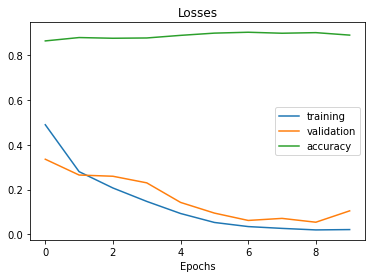

prediction comparison:

 tensor([ True,  True, False,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True, False,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True,  True, False, False,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False, False,  True,  True,  True,
         True,  True, False,  True,  Tr

In [27]:
FFL.after_training_plots(train_loss, val_loss, acc)
X, y = next(iter(test_dl))
FFL.model_test(X, y, model)
FFL.torch.save(model.state_dict(), "/content/Learning/ResNet18_trained.pt")
#model.load_state_dict(FFL.torch.load("/content/Learning/ResNet18_trained.pt"))

In [33]:
import time

In [35]:
# time to load an epoch
start = time.perf_counter()
count = 0
for b in train_dl:
    count += 1
end = time.perf_counter()
print(end - start)

18.74257307500011
